Peak intensity (# infected max): 1903 at t = 10
Peak duration (time steps at ≥½ max): 22
Time to equilibrium (within ±5% of 372): 142


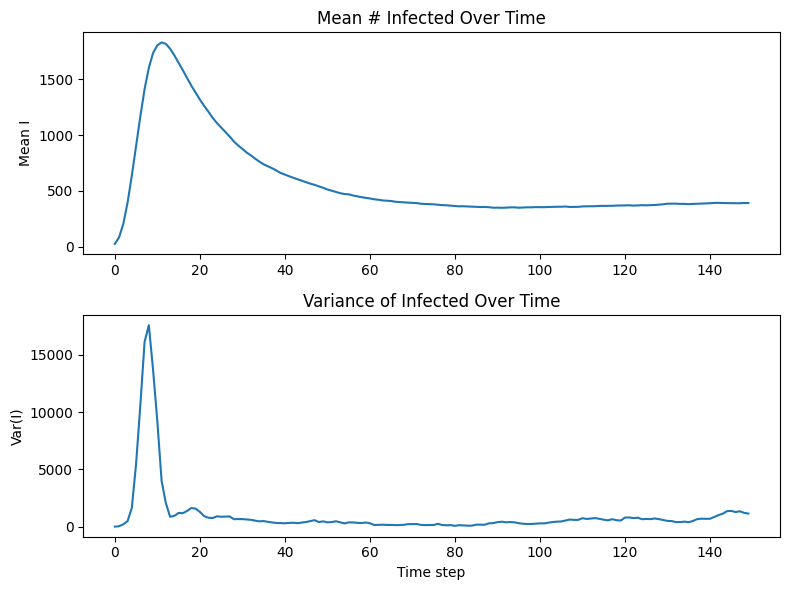

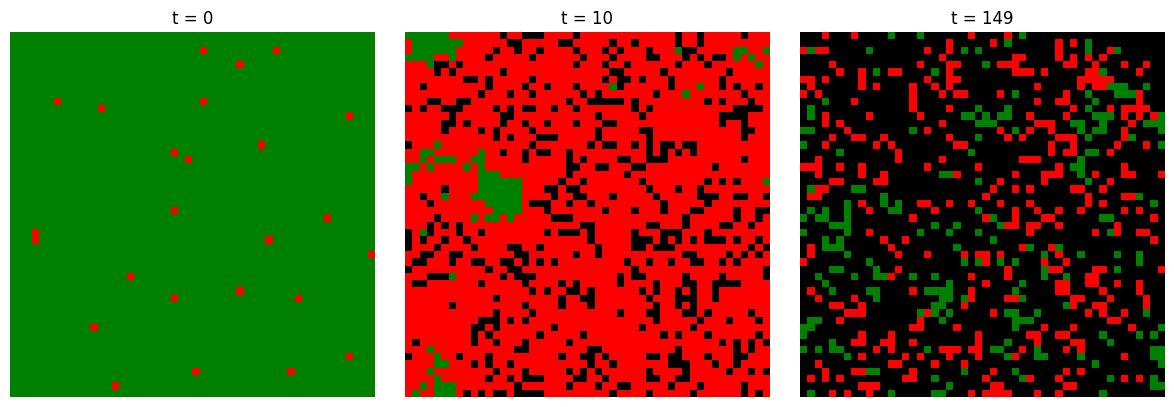

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def run_sirs_ca(grid_size, beta, gamma, delta, T, init_I_frac=0.01):
    """
    Spatial SIRS cellular automaton on a torus:
      0 = S, 1 = I, 2 = R
    β: P(S→I per infected neighbor)
    γ: P(I→R)
    δ: P(R→S)
    """
    # initialize grid
    grid = np.zeros((grid_size, grid_size), dtype=int)
    N = grid_size * grid_size
    # seed initial infections
    init_I = np.random.choice(N, size=int(init_I_frac*N), replace=False)
    grid.flat[init_I] = 1

    S_hist = np.zeros(T, int)
    I_hist = np.zeros(T, int)
    R_hist = np.zeros(T, int)
    snapshots = []

    for t in range(T):
        S_hist[t] = np.sum(grid == 0)
        I_hist[t] = np.sum(grid == 1)
        R_hist[t] = np.sum(grid == 2)
        snapshots.append(grid.copy())

        # count infected neighbors (8‑neighborhood, periodic)
        inf = (grid == 1).astype(int)
        pad = np.pad(inf, 1, mode='wrap')
        neigh = (
            pad[:-2,:-2] + pad[:-2,1:-1] + pad[:-2,2:] +
            pad[1:-1,:-2]               + pad[1:-1,2:] +
            pad[2:  ,:-2] + pad[2:  ,1:-1] + pad[2:  ,2:]
        )

        # S→I
        p_inf = 1 - (1 - beta)**neigh
        new_I = (grid == 0) & (np.random.rand(grid_size, grid_size) < p_inf)
        # I→R
        new_R = (grid == 1) & (np.random.rand(grid_size, grid_size) < gamma)
        # R→S (δ)
        new_S = (grid == 2) & (np.random.rand(grid_size, grid_size) < delta)

        grid[new_I] = 1
        grid[new_R] = 2
        grid[new_S] = 0

    return S_hist, I_hist, R_hist, snapshots

# ────────────── parameters ──────────────
grid_size = 50
beta      = 0.30    # infection prob per neighbor
gamma     = 0.05    # recovery prob
delta     = 0.01    # loss of immunity (R→S)
T         = 150
num_runs  = 10

# ────────────── run simulations ──────────────
all_S = np.zeros((num_runs, T), int)
all_I = np.zeros((num_runs, T), int)
all_R = np.zeros((num_runs, T), int)
all_snaps = []

for run in range(num_runs):
    S, I, R, snaps = run_sirs_ca(grid_size, beta, gamma, delta, T)
    all_S[run] = S
    all_I[run] = I
    all_R[run] = R
    all_snaps.append(snaps)

# ────────────── compute mean & var on I ──────────────
mean_I = all_I.mean(axis=0)
var_I  = all_I.var(axis=0)

# ────────────── compute peak & equilibrium metrics for run 0 ──────────────
I0 = all_I[0]
peak_intensity = I0.max()
peak_time      = I0.argmax()

# duration at half‑max (full‑width at half‑maximum)
half = peak_intensity / 2
above = np.where(I0 >= half)[0]
duration_peak = above[-1] - above[0] + 1  # in time steps

# equilibrium defined as when |I − I(T−1)| ≤ 5% of I(T−1)
steady = I0[-1]
tol = 0.05 * max(steady, 1)   # avoid tol=0
off = np.where(np.abs(I0 - steady) > tol)[0]
time_to_eq = (off.max() + 1) if off.size else 0

# ────────────── print metrics ──────────────
print(f"Peak intensity (# infected max): {peak_intensity} at t = {peak_time}")
print(f"Peak duration (time steps at ≥½ max): {duration_peak}")
print(f"Time to equilibrium (within ±5% of {steady}): {time_to_eq}")

# ────────────── save results ──────────────
pd.DataFrame(all_S).to_csv('data/S_runs.csv', index=False)
pd.DataFrame(all_I).to_csv('data/I_runs.csv', index=False)
pd.DataFrame(all_R).to_csv('data/R_runs.csv', index=False)
pd.DataFrame({
    'time':    np.arange(T),
    'mean_I':  mean_I,
    'var_I':   var_I
}).to_csv('data/I_stats.csv', index=False)

# ────────────── plotting ──────────────
# 1) mean & variance of I
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(mean_I)
plt.title('Mean # Infected Over Time')
plt.ylabel('Mean I')
plt.subplot(2,1,2)
plt.plot(var_I)
plt.title('Variance of Infected Over Time')
plt.xlabel('Time step')
plt.ylabel('Var(I)')
plt.tight_layout()
plt.show()

# 2) spatial snapshots with S=green, I=red, R=black
cmap = ListedColormap(['green','red','black'])
norm = BoundaryNorm([0,1,2,3], cmap.N)

times = [0, peak_time, T-1]
plt.figure(figsize=(12,4))
for i,t in enumerate(times):
    plt.subplot(1,3,i+1)
    plt.imshow(all_snaps[0][t], cmap=cmap, norm=norm, interpolation='nearest')
    plt.title(f"t = {t}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Run 0: intensity=4458, duration=196, time_to_equilibrium=None
Run 1: intensity=4569, duration=196, time_to_equilibrium=None
Run 2: intensity=4108, duration=196, time_to_equilibrium=None
Run 3: intensity=4472, duration=196, time_to_equilibrium=None
Run 4: intensity=4554, duration=196, time_to_equilibrium=None
Run 5: intensity=4321, duration=196, time_to_equilibrium=None
Run 6: intensity=4378, duration=196, time_to_equilibrium=None
Run 7: intensity=4464, duration=196, time_to_equilibrium=None
Run 8: intensity=4537, duration=196, time_to_equilibrium=None
Run 9: intensity=4687, duration=196, time_to_equilibrium=None


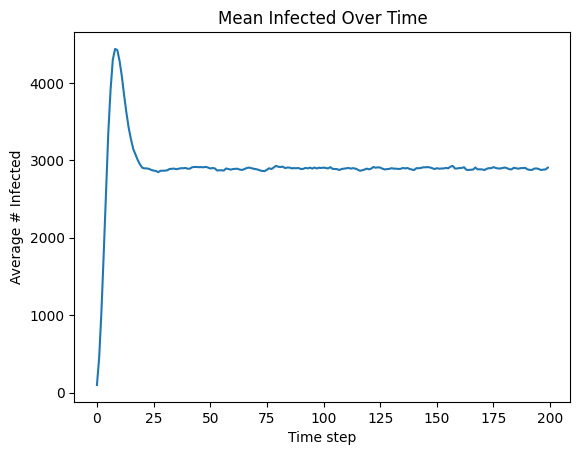

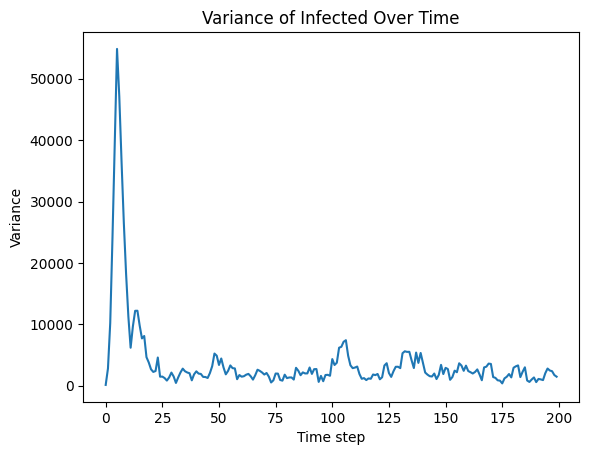

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
import random

# --- Parameters (adjust N and steps to suit your machine) ---
N = 100               # Grid size (N x N)
p = 0.5               # Infection probability
q = 0.2               # Recovery probability
delta = 0.1           # Immunity loss probability (R -> S)
steps = 200           # Number of time steps per simulation
runs = 10             # Number of simulations

# --- State codes and colormap ---
SUSCEPTIBLE, INFECTED, RECOVERED = 0, 1, 2
cmap = colors.ListedColormap(['green', 'red', 'black'])

def run_sirs(run_id):
    # Initialize grid with ~1% infected
    grid = np.zeros((N, N), dtype=int)
    grid[np.random.rand(N, N) < 0.01] = INFECTED
    
    history_I = []
    frames = []
    
    for t in range(steps):
        frames.append(grid.copy())
        history_I.append(np.sum(grid == INFECTED))
        
        new_grid = grid.copy()
        for i in range(N):
            for j in range(N):
                state = grid[i, j]
                if state == SUSCEPTIBLE:
                    # Check Moore neighbors
                    neighbors = grid[max(i-1, 0):min(i+2, N), max(j-1, 0):min(j+2, N)]
                    if (neighbors == INFECTED).any() and random.random() < p:
                        new_grid[i, j] = INFECTED
                elif state == INFECTED and random.random() < q:
                    new_grid[i, j] = RECOVERED
                elif state == RECOVERED and random.random() < delta:
                    new_grid[i, j] = SUSCEPTIBLE
        
        grid = new_grid
    
    # Create and save animation GIF
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], cmap=cmap, vmin=0, vmax=2)
    ax.axis('off')
    def update(frame):
        im.set_array(frames[frame])
        return [im]
    ani = animation.FuncAnimation(fig, update, frames=steps, blit=True)
    ani.save(f'sim_run_{run_id}.gif', writer='pillow', fps=20)
    plt.close(fig)
    
    return np.array(history_I)

# --- Run simulations and collect metrics ---
all_hist = np.zeros((runs, steps), dtype=int)
metrics = []

for rid in range(runs):
    hist = run_sirs(rid)
    all_hist[rid] = hist
    
    intensity = hist.max()
    half_max = intensity / 2.0
    duration = np.sum(hist >= half_max)  # full width at half maximum
    
    t_peak = np.argmax(hist)
    future = np.where(hist[t_peak:] <= 1)[0]
    time_to_equil = (t_peak + future[0]) if future.size > 0 else None
    
    metrics.append((rid, intensity, duration, time_to_equil))
    print(f'Run {rid}: intensity={intensity}, duration={duration}, time_to_equilibrium={time_to_equil}')

# --- Plot mean and variance of infected counts ---
mean_I = all_hist.mean(axis=0)
var_I = all_hist.var(axis=0)

plt.figure()
plt.plot(mean_I)
plt.title('Mean Infected Over Time')
plt.xlabel('Time step')
plt.ylabel('Average # Infected')

plt.figure()
plt.plot(var_I)
plt.title('Variance of Infected Over Time')
plt.xlabel('Time step')
plt.ylabel('Variance')

plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from matplotlib.animation import PillowWriter
import random
import os

# -------------------------------
# Parameters
# -------------------------------
N = 150              # Grid size (NxN)
p = 0.5              # Infection probability (S->I)
q = 0.2              # Recovery probability (I->R)
delta = 0.05         # Waning immunity (R->S) probability
steps = 200          # Time steps per simulation
n_runs = 10          # Number of replicates

# State definitions
SUSCEPTIBLE = 0
INFECTED    = 1
RECOVERED   = 2

# Colormap: S=green, I=red, R=black
cmap = colors.ListedColormap(['green','red','black'])
norm = colors.BoundaryNorm([0,1,2,3], cmap.N)

os.makedirs('counts', exist_ok=True)
os.makedirs('gifs', exist_ok=True)

def init_grid(init_inf=0.01):
    grid = np.full((N, N), SUSCEPTIBLE, dtype=int)
    for i in range(N):
        for j in range(N):
            if random.random() < init_inf:
                grid[i,j] = INFECTED
    return grid

def update_grid(grid):
    new = grid.copy()
    for i in range(N):
        for j in range(N):
            s = grid[i,j]
            if s == SUSCEPTIBLE:
                neighbors = grid[max(i-1,0):i+2, max(j-1,0):j+2].flatten()
                if INFECTED in neighbors and random.random() < p:
                    new[i,j] = INFECTED
            elif s == INFECTED:
                if random.random() < q:
                    new[i,j] = RECOVERED
            elif s == RECOVERED:
                if random.random() < delta:
                    new[i,j] = SUSCEPTIBLE
    return new

all_counts = np.zeros((n_runs, steps+1, 3), dtype=int)
metrics = []

for run in range(n_runs):
    grid = init_grid()
    counts = np.zeros((steps+1, 3), dtype=int)
    counts[0] = [np.sum(grid==SUSCEPTIBLE),
                 np.sum(grid==INFECTED),
                 np.sum(grid==RECOVERED)]
    eq_time = None

    # simulate, stop early if infections extinct
    for t in range(1, steps+1):
        grid = update_grid(grid)
        counts[t] = [np.sum(grid==SUSCEPTIBLE),
                     np.sum(grid==INFECTED),
                     np.sum(grid==RECOVERED)]
        if counts[t,1] == 0:
            eq_time = t
            # fill remaining steps with steady state
            counts[t+1:] = counts[t]
            break
    if eq_time is None:
        # never hit zero
        eq_time = steps

    all_counts[run] = counts

    # save timeseries
    np.savetxt(f'counts/counts_run_{run}.csv', counts, delimiter=',',
               header='S,I,R', comments='')

    # compute metrics
    I = counts[:,1]
    I_max = I.max()
    peak_idx = I.argmax()
    half_max = I_max/2
    above = np.where(I >= half_max)[0]
    duration = int(above[-1] - above[0]) if above.size>0 else 0

    metrics.append({
        'run': run,
        'peak_intensity': int(I_max),
        'peak_duration': duration,
        'peak_time': int(peak_idx),
        'equilibrium_time': int(eq_time)
    })

    # save spatial GIF
    frames = []
    grid = init_grid()  # re-init for gif
    frames.append(grid.copy())
    for _ in range(1, steps+1):
        grid = update_grid(grid)
        frames.append(grid.copy())

    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], cmap=cmap, norm=norm)
    ax.axis('off')
    ani = animation.FuncAnimation(fig, lambda i: im.set_data(frames[i]),
                                  frames=len(frames), interval=100)
    ani.save(f'gifs/simulation_run_{run}.gif', writer=PillowWriter(fps=10))
    plt.close(fig)

# mean & var for infected
mean_I = all_counts[:,:,1].mean(axis=0)
var_I  = all_counts[:,:,1].var(axis=0)

plt.figure()
plt.plot(mean_I, label='Mean I')
plt.plot(var_I,  label='Var I')
plt.xlabel('Time'); plt.ylabel('Count')
plt.legend(); plt.tight_layout()
plt.savefig('mean_var_infected_v1.png')
plt.close()

print("Metrics (extinction-based equilibrium):")
for m in metrics:
    print(m)

Metrics (extinction-based equilibrium):
{'run': 0, 'peak_intensity': 10067, 'peak_duration': 12, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 1, 'peak_intensity': 9772, 'peak_duration': 13, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 2, 'peak_intensity': 9958, 'peak_duration': 12, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 3, 'peak_intensity': 9493, 'peak_duration': 14, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 4, 'peak_intensity': 9876, 'peak_duration': 12, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 5, 'peak_intensity': 9799, 'peak_duration': 13, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 6, 'peak_intensity': 9667, 'peak_duration': 13, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 7, 'peak_intensity': 9746, 'peak_duration': 13, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 8, 'peak_intensity': 10113, 'peak_duration': 12, 'peak_time': 8, 'equilibrium_time': 200}
{'run': 9, 'peak_intensity': 9755, 'peak_duration': 13, 'peak_time': 8, 'equilibrium_

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import random
import os

# -------------------------------
# Define SIRS parameter cases
# -------------------------------
parameter_cases = {
    'case1_p>q>delta': {'p': 0.6, 'q': 0.3, 'delta': 0.1},
    'case2_p=q>delta': {'p': 0.4, 'q': 0.4, 'delta': 0.1},
    'case3_p>q=delta': {'p': 0.4, 'q': 0.2, 'delta': 0.2},
    'case4_p=q=delta': {'p': 0.3, 'q': 0.3, 'delta': 0.3},
}

# Common settings
N = 150
steps = 200
n_runs = 10

SUSCEPTIBLE = 0
INFECTED    = 1
RECOVERED   = 2

cmap = colors.ListedColormap(['green', 'red', 'black'])
norm_grid = colors.BoundaryNorm([0,1,2,3], cmap.N)

def init_grid(init_inf=0.01):
    grid = np.full((N, N), SUSCEPTIBLE, dtype=int)
    for i in range(N):
        for j in range(N):
            if random.random() < init_inf:
                grid[i, j] = INFECTED
    return grid

def update_grid(grid, p, q, delta):
    new = grid.copy()
    for i in range(N):
        for j in range(N):
            s = grid[i, j]
            if s == SUSCEPTIBLE:
                neigh = grid[max(i-1,0):i+2, max(j-1,0):j+2].flatten()
                if INFECTED in neigh and random.random() < p:
                    new[i, j] = INFECTED
            elif s == INFECTED:
                if random.random() < q:
                    new[i, j] = RECOVERED
            elif s == RECOVERED:
                if random.random() < delta:
                    new[i, j] = SUSCEPTIBLE
    return new

for case_name, params in parameter_cases.items():
    p, q, delta = params['p'], params['q'], params['delta']
    case_dir = f"output_{case_name}"
    os.makedirs(f"{case_dir}/counts", exist_ok=True)
    os.makedirs(f"{case_dir}/gifs", exist_ok=True)

    all_counts = np.zeros((n_runs, steps+1, 3), dtype=int)
    metrics = []

    for run in range(n_runs):
        grid = init_grid()
        counts = np.zeros((steps+1, 3), dtype=int)
        counts[0] = [np.sum(grid==SUSCEPTIBLE),
                     np.sum(grid==INFECTED),
                     np.sum(grid==RECOVERED)]
        frames = [grid.copy()]

        for t in range(1, steps+1):
            grid = update_grid(grid, p, q, delta)
            counts[t] = [np.sum(grid==SUSCEPTIBLE),
                         np.sum(grid==INFECTED),
                         np.sum(grid==RECOVERED)]
            frames.append(grid.copy())

        all_counts[run] = counts
        np.savetxt(f"{case_dir}/counts/counts_run_{run}.csv",
                   counts, delimiter=',', header='S,I,R', comments='')

        # Peak metrics
        I = counts[:,1]
        I_max = I.max()
        half_max = I_max / 2
        above = np.where(I >= half_max)[0]
        duration = int(above[-1] - above[0]) if above.size > 0 else 0

        # Window-based equilibrium
        threshold_abs = 1
        window = 10
        eq_time = None
        peak_idx = int(np.argmax(I))
        for t in range(peak_idx, steps+1-window):
            seg = I[t:t+window]
            if seg.max() - seg.min() <= threshold_abs:
                eq_time = int(t)
                break
        if eq_time is None:
            eq_time = steps

        metrics.append({
            'run': run,
            'peak_intensity': int(I_max),
            'peak_duration': duration,
            'equilibrium_time': eq_time
        })

        # Save GIF
        fig, ax = plt.subplots()
        im = ax.imshow(frames[0], cmap=cmap, norm=norm_grid)
        ax.axis('off')
        ani = animation.FuncAnimation(
            fig, lambda i: im.set_data(frames[i]),
            frames=len(frames), interval=100
        )
        ani.save(f"{case_dir}/gifs/simulation_{run}.mp4",
                 writer='ffmpeg', fps=10)
        plt.close(fig)

    # Plot mean & variance
    mean_I = all_counts[:,:,1].mean(axis=0)
    var_I  = all_counts[:,:,1].var(axis=0)

    plt.figure()
    plt.plot(mean_I, label='Mean I')
    plt.plot(var_I,  label='Var I')
    plt.xlabel('Time'); plt.ylabel('Infected count')
    plt.title(f"Mean/Var Infected – {case_name}")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"{case_dir}/mean_var_infected.png")
    plt.close()

    # --- NEW: Bar plots for each case with Viridis color scheme ---
    runs = list(range(n_runs))
    peak_intensities = [m['peak_intensity'] for m in metrics]
    peak_durations   = [m['peak_duration']  for m in metrics]

    norm_runs = plt.Normalize(0, n_runs-1)
    colors = cm.viridis(norm_runs(runs))

    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    # Duration bar chart
    axs[0].bar(runs, peak_durations, color=colors)
    axs[0].set_ylabel('Peak Duration')
    axs[0].set_title(f'Peak Duration per Run ({case_name})')
    # Intensity bar chart
    axs[1].bar(runs, peak_intensities, color=colors)
    axs[1].set_ylabel('Peak Intensity')
    axs[1].set_xlabel('Run Number')
    axs[1].set_title(f'Peak Intensity per Run ({case_name})')
    plt.tight_layout()
    plt.savefig(f"{case_dir}/peak_stats_bars_viridis.png")
    plt.close()

    # Print summary
    print(f"\n=== Results for {case_name} (p={p}, q={q}, δ={delta}) ===")
    for m in metrics:
        print(m)



=== Results for case1_p>q>delta (p=0.6, q=0.3, δ=0.1) ===
{'run': 0, 'peak_intensity': 8479, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 1, 'peak_intensity': 8807, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 2, 'peak_intensity': 8179, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 3, 'peak_intensity': 8631, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 4, 'peak_intensity': 8469, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 5, 'peak_intensity': 8111, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 6, 'peak_intensity': 8731, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 7, 'peak_intensity': 8627, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 8, 'peak_intensity': 8460, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 9, 'peak_intensity': 8255, 'peak_duration': 197, 'equilibrium_time': 200}

=== Results for case2_p=q>delta (p=0.4, q=0.4, δ=0.1) ===
{'run': 0, 'peak_intensity': 5861, 'peak_duration': 196, 'equi

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import random
import os

# -------------------------------
# Define SIRS parameter cases
# -------------------------------
parameter_cases = {
    'case1_p>q>delta': {'p': 0.6, 'q': 0.3, 'delta': 0.1},
    'case2_p=q>delta': {'p': 0.4, 'q': 0.4, 'delta': 0.1},
    'case3_p>q=delta': {'p': 0.4, 'q': 0.2, 'delta': 0.2},
    'case4_p=q=delta': {'p': 0.3, 'q': 0.3, 'delta': 0.3},
}

# Common settings
N = 150
steps = 200
n_runs = 10

SUSCEPTIBLE = 0
INFECTED    = 1
RECOVERED   = 2

# For the grid animation
cmap = colors.ListedColormap(['green', 'red', 'black'])
norm_grid = colors.BoundaryNorm([0,1,2,3], cmap.N)

def init_grid(init_inf=0.01):
    grid = np.full((N, N), SUSCEPTIBLE, dtype=int)
    for i in range(N):
        for j in range(N):
            if random.random() < init_inf:
                grid[i, j] = INFECTED
    return grid

def update_grid(grid, p, q, delta):
    new = grid.copy()
    for i in range(N):
        for j in range(N):
            state = grid[i, j]
            if state == SUSCEPTIBLE:
                neigh = grid[max(i-1,0):i+2, max(j-1,0):j+2].flatten()
                if INFECTED in neigh and random.random() < p:
                    new[i, j] = INFECTED
            elif state == INFECTED:
                if random.random() < q:
                    new[i, j] = RECOVERED
            elif state == RECOVERED:
                if random.random() < delta:
                    new[i, j] = SUSCEPTIBLE
    return new

for case_name, params in parameter_cases.items():
    p, q, delta = params['p'], params['q'], params['delta']
    case_dir = f"output_{case_name}"
    os.makedirs(f"{case_dir}/counts", exist_ok=True)
    os.makedirs(f"{case_dir}/gifs", exist_ok=True)

    all_counts = np.zeros((n_runs, steps+1, 3), dtype=int)
    metrics = []

    for run in range(n_runs):
        # -- simulate one run
        grid = init_grid()
        counts = np.zeros((steps+1, 3), dtype=int)
        counts[0] = [
            np.sum(grid==SUSCEPTIBLE),
            np.sum(grid==INFECTED),
            np.sum(grid==RECOVERED)
        ]
        frames = [grid.copy()]

        for t in range(1, steps+1):
            grid = update_grid(grid, p, q, delta)
            counts[t] = [
                np.sum(grid==SUSCEPTIBLE),
                np.sum(grid==INFECTED),
                np.sum(grid==RECOVERED)
            ]
            frames.append(grid.copy())

        all_counts[run] = counts
        # save raw counts
        np.savetxt(
            f"{case_dir}/counts/counts_run_{run}.csv",
            counts,
            delimiter=',',
            header='S,I,R',
            comments=''
        )

        # compute peak metrics
        I = counts[:,1]
        I_max = I.max()
        half_max = I_max / 2
        above = np.where(I >= half_max)[0]
        duration = int(above[-1] - above[0]) if above.size > 0 else 0

        # Equilibrium time = last time any I > 0 (Model 1 style)
        nonzero = np.where(I > 0)[0]
        eq_time = int(nonzero.max()) if nonzero.size else 0

        metrics.append({
            'run': run,
            'peak_intensity': int(I_max),
            'peak_duration': duration,
            'equilibrium_time': eq_time
        })

        # Save GIF for this run
        fig, ax = plt.subplots()
        im = ax.imshow(frames[0], cmap=cmap, norm=norm_grid)
        ax.axis('off')
        ani = animation.FuncAnimation(
            fig,
            lambda i: im.set_data(frames[i]),
            frames=len(frames),
            interval=100
        )
        ani.save(
            f"{case_dir}/gifs/simulation_{run}.mp4",
            writer='ffmpeg',
            fps=10
        )
        plt.close(fig)

        # --- NEW: snapshots at t=0,20,150 ---
        snapshot_times = [0, 10, 150]
        fig_snap, axes = plt.subplots(1, len(snapshot_times), figsize=(12, 4))
        for ax, t_snap in zip(axes, snapshot_times):
            ax.imshow(frames[t_snap], cmap=cmap, norm=norm_grid)
            ax.set_title(f"t = {t_snap}")
            ax.axis('off')
        fig_snap.tight_layout()
        fig_snap.savefig(f"{case_dir}/gifs/simulation_{run}_snapshots.png")
        plt.close(fig_snap)


    # -- after all runs: plot mean & var
    mean_I = all_counts[:,:,1].mean(axis=0)
    var_I  = all_counts[:,:,1].var(axis=0)

    plt.figure()
    plt.plot(mean_I, label='Mean I')
    plt.plot(var_I,  label='Var I')
    plt.xlabel('Time')
    plt.ylabel('Infected count')
    plt.title(f"Mean/Var Infected – {case_name}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{case_dir}/mean_var_infected.png")
    plt.close()

    # -- bar plots of peak duration & intensity
    runs = list(range(n_runs))
    peak_intensities = [m['peak_intensity'] for m in metrics]
    peak_durations   = [m['peak_duration']  for m in metrics]

    norm_runs = plt.Normalize(0, n_runs-1)
    viridis_colors = cm.viridis(norm_runs(runs))

    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    axs[0].bar(runs, peak_durations, color=viridis_colors)
    axs[0].set_ylabel('Peak Duration')
    axs[0].set_title(f'Peak Duration per Run ({case_name})')
    axs[1].bar(runs, peak_intensities, color=viridis_colors)
    axs[1].set_ylabel('Peak Intensity')
    axs[1].set_xlabel('Run Number')
    axs[1].set_title(f'Peak Intensity per Run ({case_name})')
    plt.tight_layout()
    plt.savefig(f"{case_dir}/peak_stats_bars_viridis.png")
    plt.close()

    # Print summary to console
    print(f"\n=== Results for {case_name} (p={p}, q={q}, δ={delta}) ===")
    for m in metrics:
        print(m)



=== Results for case1_p>q>delta (p=0.6, q=0.3, δ=0.1) ===
{'run': 0, 'peak_intensity': 8543, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 1, 'peak_intensity': 8121, 'peak_duration': 196, 'equilibrium_time': 200}
{'run': 2, 'peak_intensity': 8238, 'peak_duration': 196, 'equilibrium_time': 200}
{'run': 3, 'peak_intensity': 8432, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 4, 'peak_intensity': 8758, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 5, 'peak_intensity': 8108, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 6, 'peak_intensity': 8433, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 7, 'peak_intensity': 7936, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 8, 'peak_intensity': 8292, 'peak_duration': 197, 'equilibrium_time': 200}
{'run': 9, 'peak_intensity': 8827, 'peak_duration': 197, 'equilibrium_time': 200}

=== Results for case2_p=q>delta (p=0.4, q=0.4, δ=0.1) ===
{'run': 0, 'peak_intensity': 5736, 'peak_duration': 196, 'equi